# Variational autoencoder for face recognition problem

## Preparing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

from PIL import Image

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

attrs = attrs.astype(float)
attrs

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.195580,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.139990,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.360060,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.397680,0.874160,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.666760,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.082680,-0.439614,-0.359859,-0.760774,-0.410152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,-0.205363,-0.202842,-1.232735,-1.409125,-1.804858,0.287268,-0.521815,-0.789165,-1.008119,0.531813,...,-0.867156,-0.879554,-0.179497,0.323676,-2.188852,-1.169369,0.924397,-0.217415,-0.414024,-0.495178
13139,1.957472,-2.472470,-1.307994,-0.671636,-1.960125,-0.838803,-1.365955,0.510448,-1.262193,0.418947,...,-2.487289,2.608861,-0.954190,-1.599463,-1.238220,-1.187034,1.874130,-0.832614,0.152785,-0.554331
13140,-0.037001,-1.164150,0.228494,0.187503,-1.836475,-0.958412,-0.669697,-0.480330,0.493433,-1.893151,...,-1.938639,-0.491080,0.495067,-0.524767,-1.073731,0.111010,0.976262,-0.453027,-0.399981,-1.078655
13141,0.282219,-0.396198,1.270470,-1.981209,-1.702940,-1.507203,-2.330721,-0.295928,1.056618,-1.613698,...,-0.662101,-1.692131,1.284772,-0.808180,-0.710051,0.694621,0.936065,-0.767500,1.146930,-0.260940


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(data, attrs, test_size=0.2)

In [ ]:
def get_images(dataset_type='train'):
    if dataset_type == 'train':
        return X_train, Y_train.values[:]
    elif dataset_type == 'val':
        return X_val, Y_val.values[:]


class FaceDataset(Dataset):
    def __init__(self, dataset_type, transform, aug=None,):
        self.images, self.attrs = get_images(dataset_type)
        self.transform = transforms
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        attr = self.attrs[idx]

        sample = {
            'image': img,
            'attr': attr
        }

        sample['image'] = torch.tensor(sample['image'])
        sample['attr'] = torch.tensor(sample['attr'])

        return sample['image'], sample['attr']

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = FaceDataset('train', transform)
val_data = FaceDataset('val', transform)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

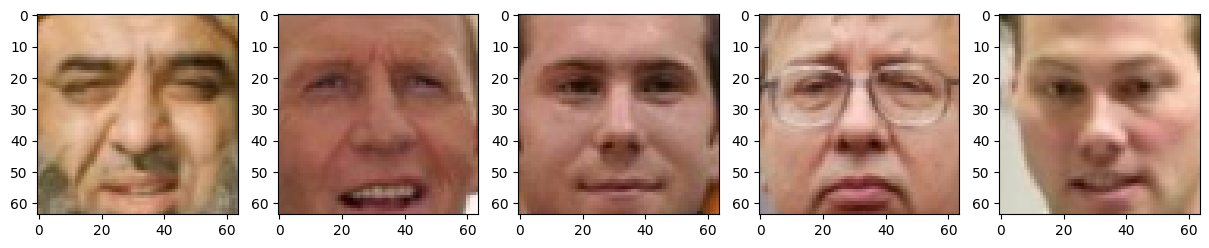

In [ ]:
X_batch, Y_batch = next(iter(train_loader))

fig, axs = plt.subplots(1, 5, figsize=(3 * 5, 5))

for idx, ax in enumerate(axs):
    ax.imshow(X_batch[idx])

plt.show()

In [ ]:
X_batch.shape

torch.Size([64, 64, 64, 3])

## Constructing Encoder, Decoder, VAE models

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()

        self.hidden_size = hidden_size

        self.conv1 = nn.Sequential(
            # input
            # image: 3 x 64 x 64

            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            # image: 6 x 62 x 62
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            # image: 12 x 60 x 60
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # image: 12 x 30 x 30

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            # image: 24 x 28 x 28
            nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(36),
            # image: 36 x 26 x 26
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # image: 36 x 13 x 13

        self.linear = nn.Sequential(
            nn.Linear(in_features=13*13*36, out_features=13*13*12),
            nn.ReLU(),
            # vector: 13*13*12
            nn.Linear(in_features=13*13*12, out_features=2*hidden_size)
            # output: 2*hidden_size
        )

    def forward(self, x):
        # x: [64, 64, 64, 3]
        # x: [BATCH_SIZE, WIDTH, HEIGHT, CHANNELS]
        # x: [B, H, W, C]

        x = x.permute(0, 3, 1, 2)

        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)

        x = x.reshape(-1, 36*13*13)
        x = self.linear(x)

        x = x.view(-1, 2, self.hidden_size)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma


In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()

        self.hidden_size = hidden_size

        # input image
        # input 13 x 13 x 36

        self.linear = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=60*60),
            nn.ReLU(),
            nn.Linear(in_features=60*60, out_features=60*60*12)
        )

        # # image: 60 x 60 x 12

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            # image: 62 x 62 x 6

            nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3),
            # output: 64 x 64 x 3
        )

    def forward(self, x):
        # x: [B, hidden_size]

        x = self.linear(x)
        x = x.reshape(-1, 12, 60, 60)
        x = self.conv(x)
        x = torch.sigmoid(x).view(-1, 3, 64, 64)

        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, hidden_size=80):
        super().__init__()

        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (std * eps)
            return sample
        else:
            return mu

    def forward(self, x):
        x = x.float()

        mu, logsigma = self.encoder(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(z)

        return mu, logsigma, reconstruction

## Training

Loss function consists of two losses:
- KL divergence
- BCELoss

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    # loss = nn.MSELoss()
    x = x.float()

    if reconstruction.size() != x.size():
        raise Exception(f'Recon size: {reconstruction.size()} not equals x size: {x.size()}')
        return 0

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from IPython.display import clear_output

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    losses = {
        'train': [],
        'test': []
    }

    for epoch in range(epochs):
        # training
        avg_loss = 0
        model.train()

        for X_batch, Y_batch in data_tr:
            X_batch_cuda = X_batch.to(device)
            opt.zero_grad()
            mu, logsigma, recon = model.forward(X_batch_cuda)
            recon = recon.permute(0, 2, 3, 1)
            loss = loss_fn(X_batch_cuda, mu, logsigma, recon)

            loss.backward()
            opt.step()
            avg_loss += loss

        avg_loss /= len(data_tr)

        # validation
        X_val, Y_val = next(iter(data_val))
        X_val_cuda = X_val.to(device)

        model.eval()
        with torch.no_grad():
            mu, logsigma, recon = model.forward(X_val_cuda)
        recon = recon.permute(0, 2, 3, 1)
        val_loss = loss_fn(X_val_cuda, mu, logsigma, recon)

        losses['train'].append(avg_loss.item())
        losses['test'].append(val_loss.item())

        clear_output(wait=True)
        print(f'Epoch: {epoch+1}/{epochs}. Train loss: {avg_loss}. Val loss: {val_loss}.')

        fig, (row0, row1, row2) = plt.subplots(3, 5, figsize=(20, 12))

        row0[0].plot(losses['train'], label='train')
        row0[0].plot(losses['test'], label='test')
        row0[0].legend()

        for i in range(5):
            row1[i].imshow(X_val[i].numpy())
            row2[i].imshow(recon[i].cpu().detach().numpy())
        plt.show()

    return losses

In [ ]:
hidden_size = 50
v_autoencoder = VAE(hidden_size=hidden_size).to(device)

epoches = 35
lr = 3e-4
criterion = loss_vae
optimizer = torch.optim.Adam(v_autoencoder.parameters(), lr=lr)

Epoch: 35/35. Train loss: 474612.6875. Val loss: 479513.625.


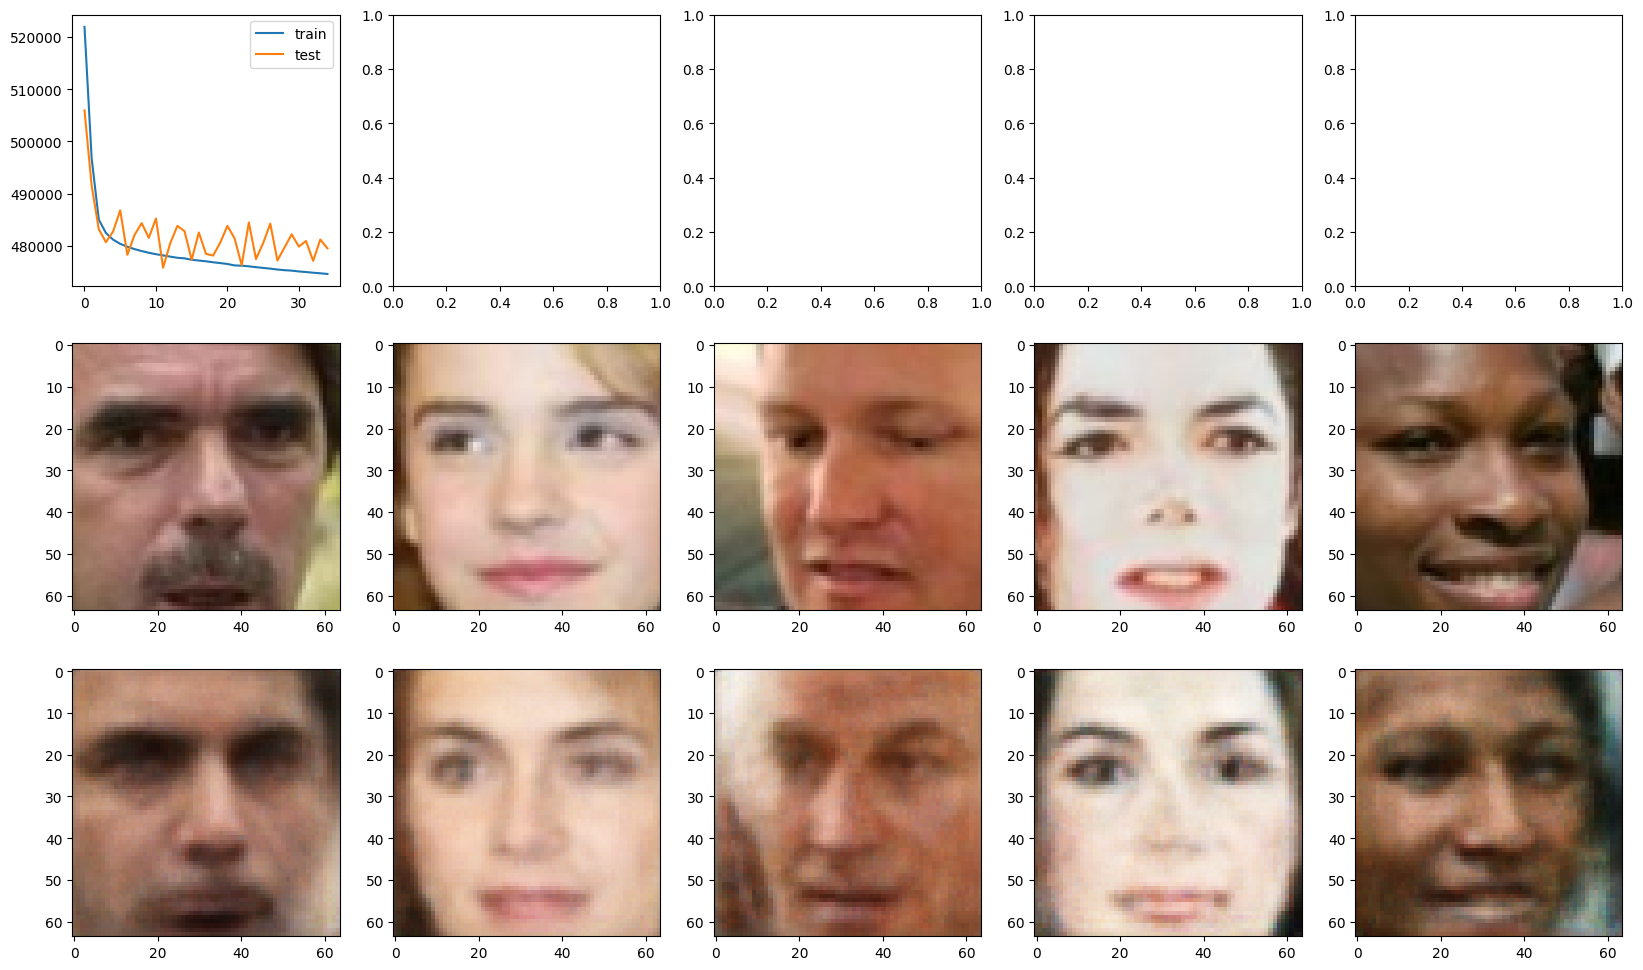

In [ ]:
losses = train(v_autoencoder, optimizer, criterion, epoches, train_loader, val_loader)

## Testing

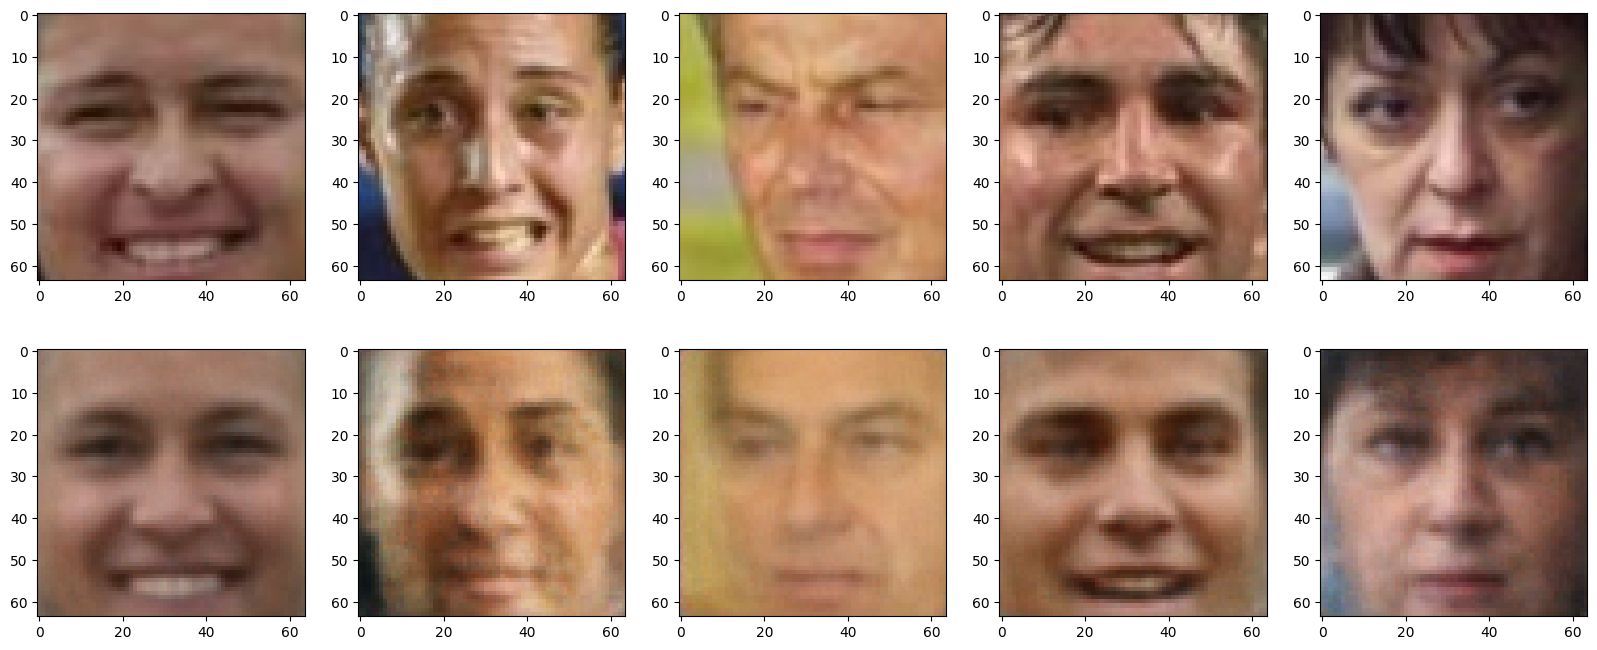

In [ ]:
fig, (row1, row2) = plt.subplots(2, 5, figsize=(20, 8))

X_val, _ = next(iter(val_loader))
v_autoencoder.eval()

with torch.no_grad():
    _, _, reconstr = v_autoencoder.forward(X_val.to(device))

reconstr = reconstr.permute(0, 2, 3, 1)

for i in range(5):
    row1[i].imshow(X_val[i].numpy())
    row2[i].imshow(reconstr[i].cpu().detach().numpy())

plt.show()

## Saving

In [ ]:
PATH = '/content/drive/MyDrive/FaceVAE_weights.saved'

torch.save(v_autoencoder.state_dict(), PATH)

## Example of only-encoder usage

In [ ]:
X_val, _ = next(iter(val_loader))
X_val = X_val.float().to(device)
v_autoencoder.eval()

with torch.no_grad():
    mu, logsigma = v_autoencoder.encoder.forward(X_val.to(device))

mu

tensor([[ 0.5094, -0.5964,  0.0943,  ..., -0.0730, -0.2097,  0.5916],
        [ 0.4239, -0.0113, -0.8239,  ..., -0.7616,  0.7554,  1.0151],
        [ 0.4127, -0.6078, -0.0404,  ..., -0.9564,  0.9866,  0.2273],
        ...,
        [ 0.0124, -0.3090, -0.2001,  ..., -1.2678,  1.6637, -0.7765],
        [ 0.7378, -0.5639,  0.3341,  ...,  0.2505,  0.0924, -0.7872],
        [ 1.8039,  0.1514,  0.1662,  ..., -0.0289,  1.1275,  0.5659]],
       device='cuda:0')

In [ ]:
mu.shape

torch.Size([64, 50])